In [1]:
import os
import glob
import itertools
from random import randint
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
from pathlib import Path
import time

import matplotlib.cm as cm
from IPython.display import Image
import git

from rmgpy.molecule import Molecule
from rmgpy.data.base import Database

## Inputs

In [2]:
rmg_model_path = '../ammonia/'
analysis_path = '../ammonia_analysis/'

## Git-python: checkout master branch

In [3]:
import git
repo = git.Repo(rmg_model_path)
date = time.localtime(repo.head.commit.committed_date)
git_date = f"{date[0]}_{date[1]}_{date[2]}_{date[3]}{date[4]}"
git_sha = str(repo.head.commit)[0:6]
git_msg = str(repo.head.commit.message)[0:50].replace(" ", "_").replace("'", "_").replace("\n", "")

current_commit = f"{git_date}_{git_sha}_{git_msg}"

current_commit

'2021_5_18_2029_8641bc_updated_Rebrov_673K'

## checkout 1 commit back

In [5]:
# repo.git.checkout('HEAD^1')
# sha = str(repo.head.commit)
# msg = str(repo.head.commit.message)
# print(sha,': ', msg)

## checkout 2 commits back

In [6]:
# repo = git.Repo('/work/westgroup/lee.ting/cantera/ammonia/')
# repo.git.checkout('HEAD^1')
# sha = repo.head.commit
# msg = repo.head.commit.message
# print(sha,': ', msg)

## Read in data
get a list of the commit folders in this repo

In [4]:
commit_list = []

# read in each filename into dictionary. 
for path in Path(analysis_path).rglob('*.csv'):
    path_str = str(path)
    start_index = path_str.find(analysis_path)
    
    if start_index != -1:
        commit = path_str[(start_index+len(analysis_path)):]
        if "\n" in commit:
            end_char = commit.index("\n")
        else: 
            end_char = commit.index("/")
        
        commit = commit[:end_char]
        if commit not in commit_list:
            commit_list.append(commit)
        
print(commit_list)   

['2021_5_18_2029_8641bc_updated_Rebrov_673K', '2021_5_8_1014_b027c2_added_base_folder_with_Rebrov_Pt673K', 'b027c2_added_base_folder_wi']


#### Read last line from each CSV file to get the outlet concentrations from the PFR, if "one_commit" is true, only run the master commit 

In [5]:
data_dict = {}

# if one_commit is true, runs analysis on current commit only
one_commit = False
if one_commit == True:
    commit_list = [current_commit]
    
for commit in commit_list:
    first_file = True
    for path in Path('../ammonia_analysis/').rglob('*.csv'):
        path_str = str(path)
        if os.stat(path_str).st_size != 0:
            if first_file == True: 
                data = pd.read_csv(path_str)
                aggdata = data.tail(1)
                first_file = False
            else: 
                data = pd.read_csv(path_str)
                aggdata = aggdata.append(data.tail(1))
            data_dict.update({commit:aggdata})

## Reproduce plots from Rebrov

Rebrov, E. V., De Croon, M. H. J. M., & Schouten, J. C. (2002). Development of the kinetic model of platinum catalyzed ammonia oxidation in a microreactor. Chemical Engineering Journal, 90(1–2), 61–76. https://doi.org/10.1016/S1385-8947(02)00068-2


for reference: 

### $conversion(\%) = \frac{moles\_fed - moles\_out}{moles\_fed} $

### $selectivity(\%, N_2) = \frac{(2*r_{L6}+r_{L13})100}{r_{L5}} $

### $selectivity(\%, N_{2}O) = \frac{(2*r_{L7}-r_{L13})100}{r_{L5}} $

In [ ]:
Image('Images/Rebrov_table2.png')

### Figure 3

### create partial pressure, selectivity, and concentration columns in the dataframe

#### choose species

In [6]:
# species partial pressures (for X-axis of plots)
p_p_species = ['NH3(6)']

conversion_species = ['NH3(6)']
selectivity_species = ['N2(4)','N2O(7)','NO(5)']

# this is H-site adsorption. no way to tell that from cantera 
coverage_species_1 = ['OX(10)', 'HOX(13)', 'X(1)'] 

# this is N-site adsorption. no way to tell that from cantera
coverage_species_2 = ['NOX(27)', 'NX(59)', 'H3NX(29)', 'X(1)']

#### NH3 conversion

In [8]:
for commit in commit_list:
    for i in conversion_species:
        data_dict[commit]['NH3(6) conversion (%)'] = 100*(data_dict[commit]['X_nh3 initial'] - 
                                                data_dict[commit][i])/data_dict[commit]['X_nh3 initial']

#### NH3 initial partial pressure

In [9]:
for commit in commit_list:
    data_dict[commit][f'NH3(6) partial pressure (atm)'] =  data_dict[commit]['X_nh3 initial']*data_dict[commit]['P (Pa)']/101325

#### O2 partial pressure

In [10]:
for commit in commit_list:
    data_dict[commit]['O2(2) partial pressure (atm)'] =  data_dict[commit]['X_o2 initial']*(data_dict[commit]['P (Pa)']/101325)
    data_dict[commit]['O2(2) partial pressure (atm)'] = data_dict[commit]['O2(2) partial pressure (atm)'].round(decimals=2)

In [11]:
for commit in commit_list:
    data_dict[commit]['N2(4) partial pressure (atm)'] =  data_dict[commit]['N2(4)']*(data_dict[commit]['P (Pa)']/101325)
    data_dict[commit]['N2(4) partial pressure (atm)'] = data_dict[commit]['N2(4) partial pressure (atm)'].round(decimals=2)


### plot

#### get a list of temperatures used

In [12]:
for i in p_p_species:
    temps = data_dict[commit_list[0]]['T (C)'].unique()
print(temps)

[400 550 700 nan]


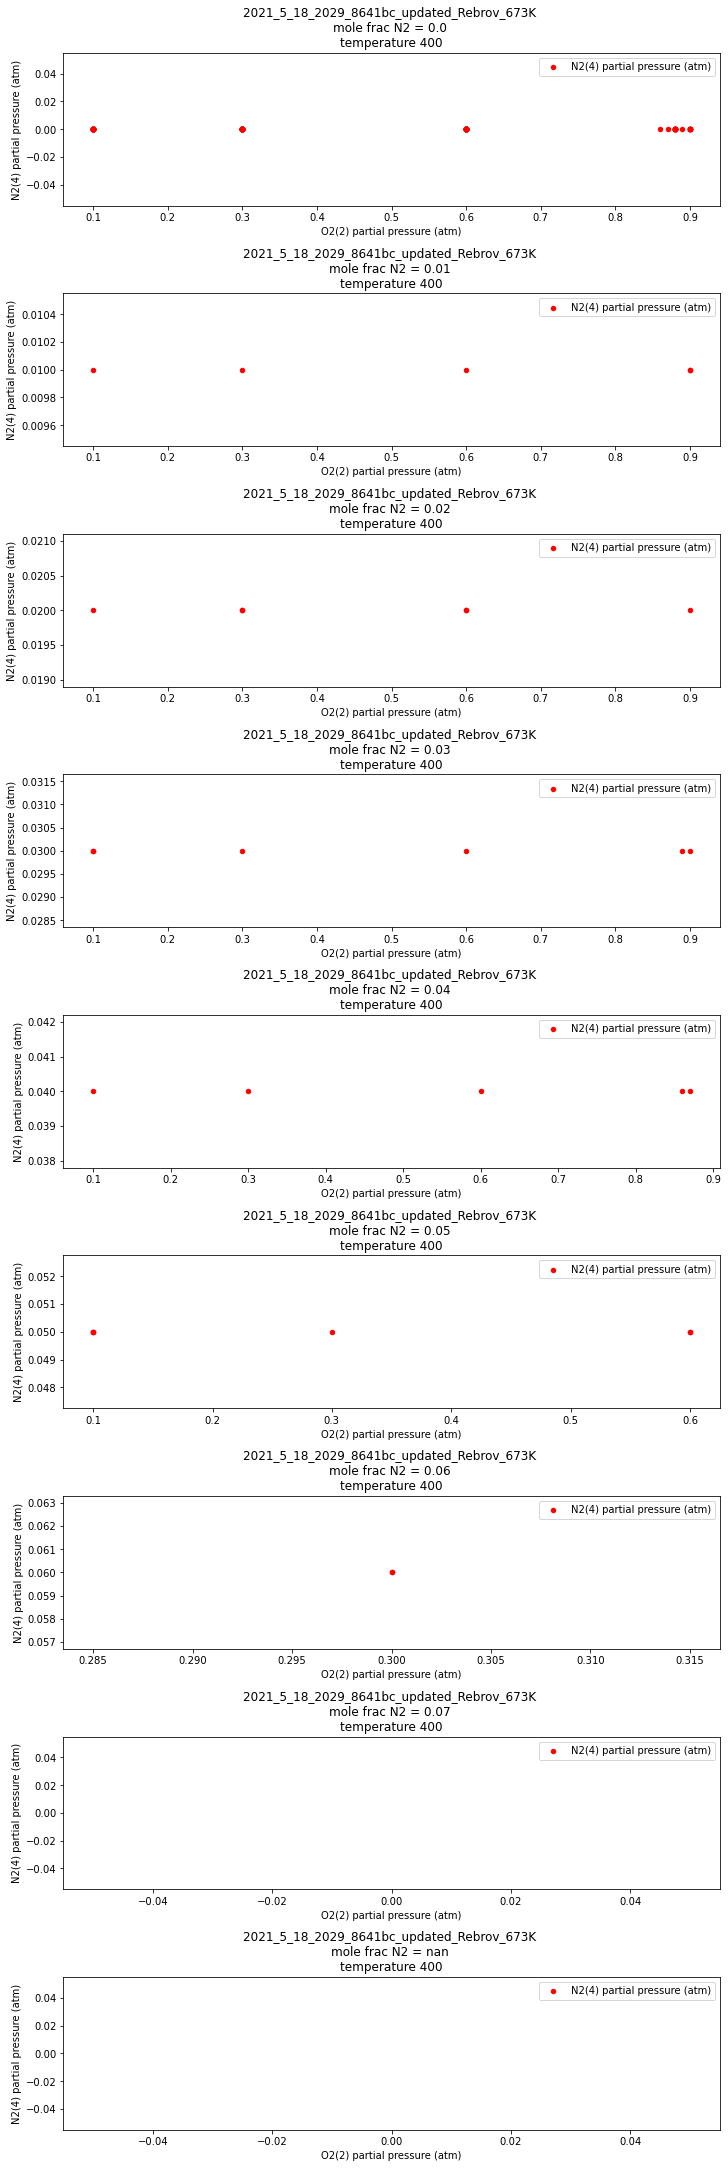

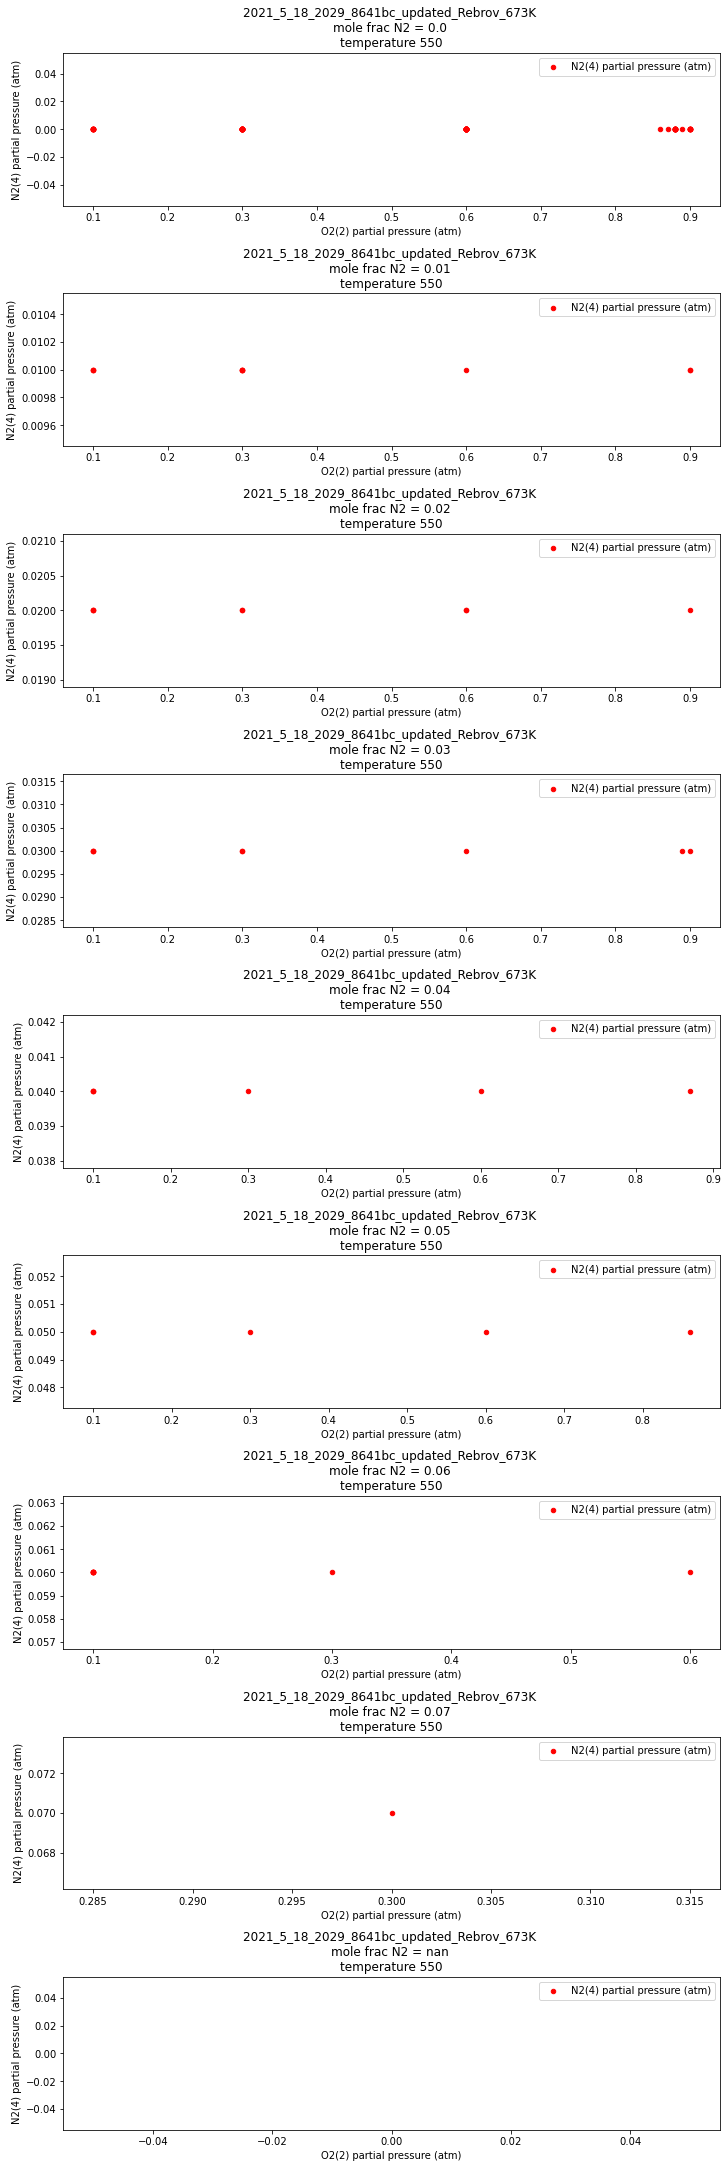

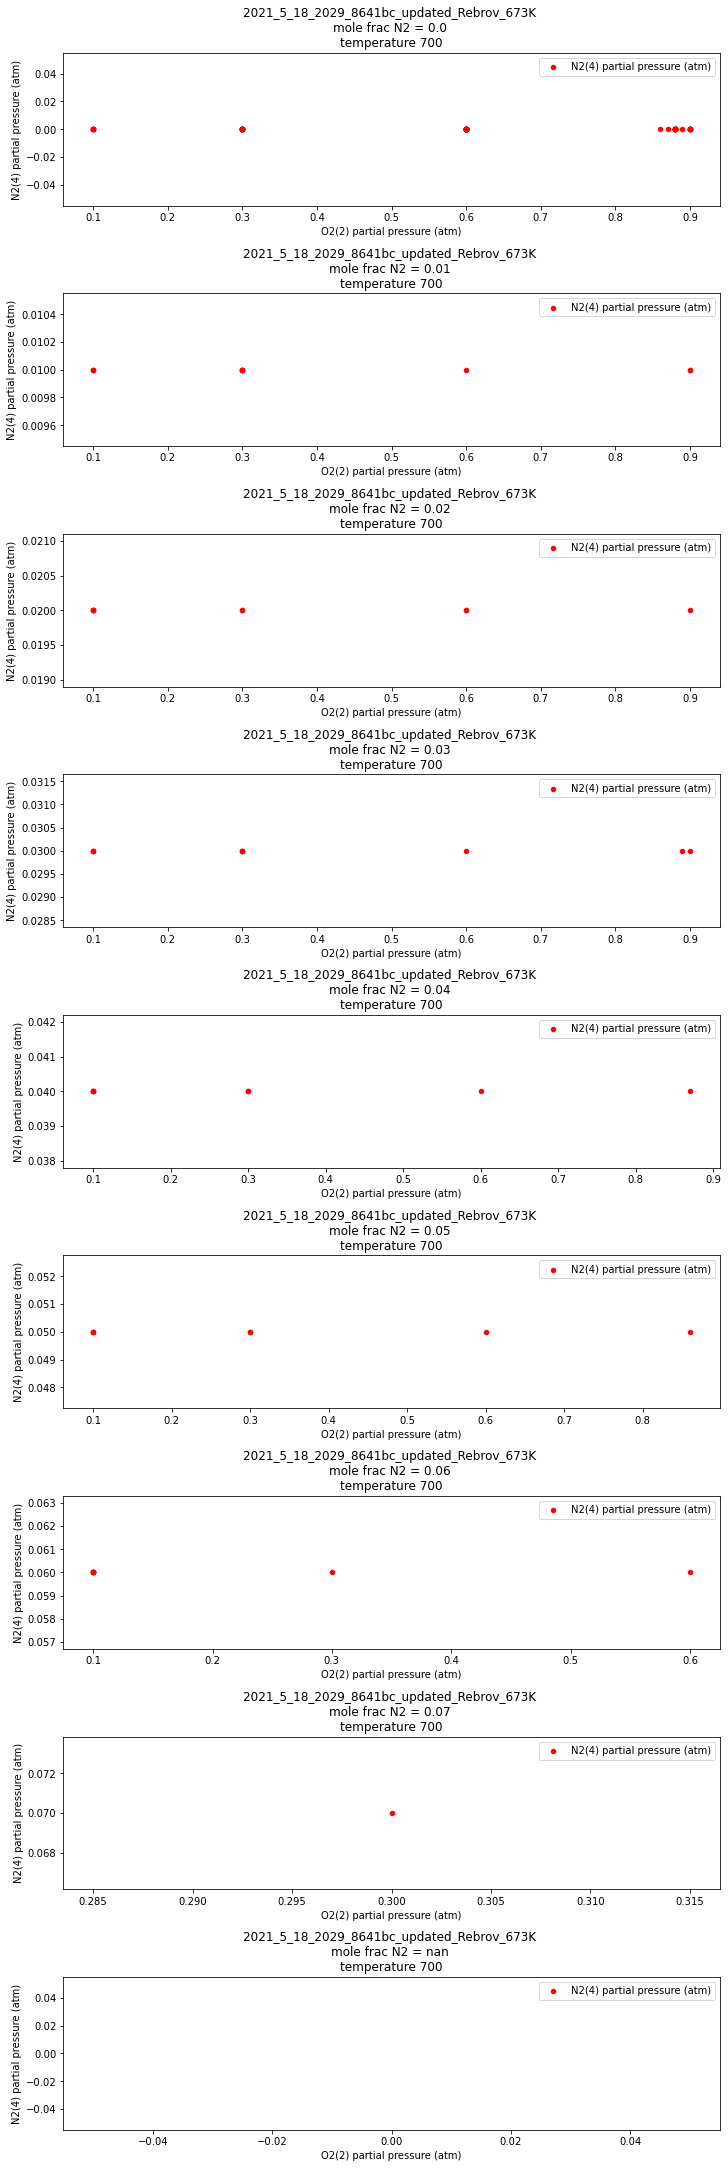

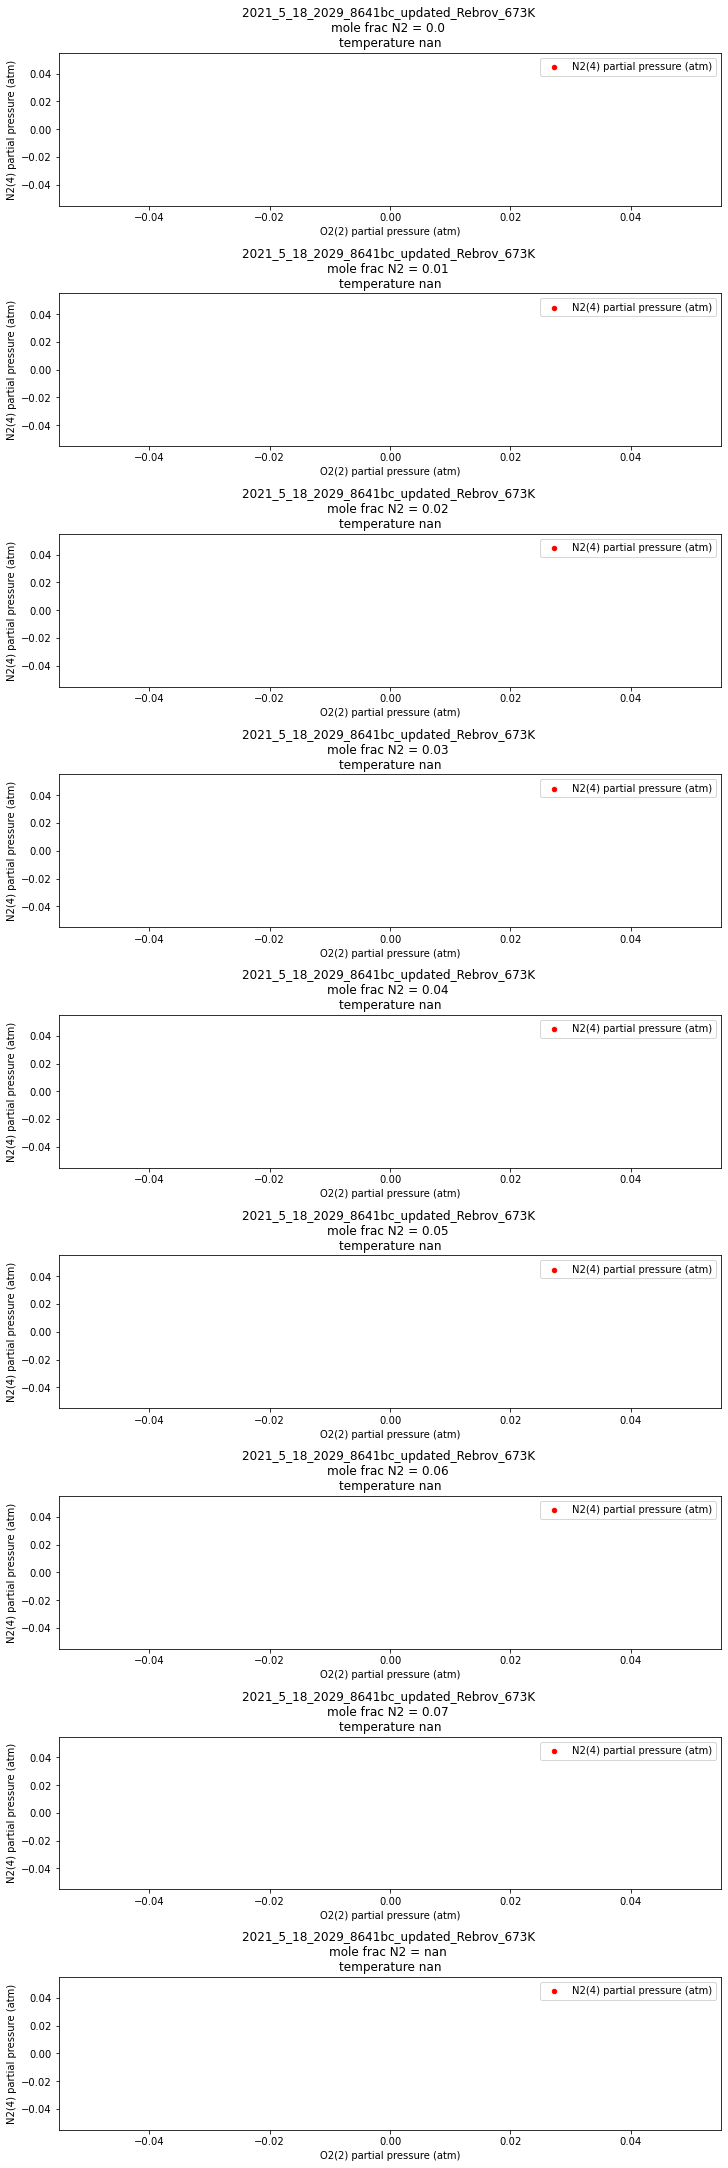

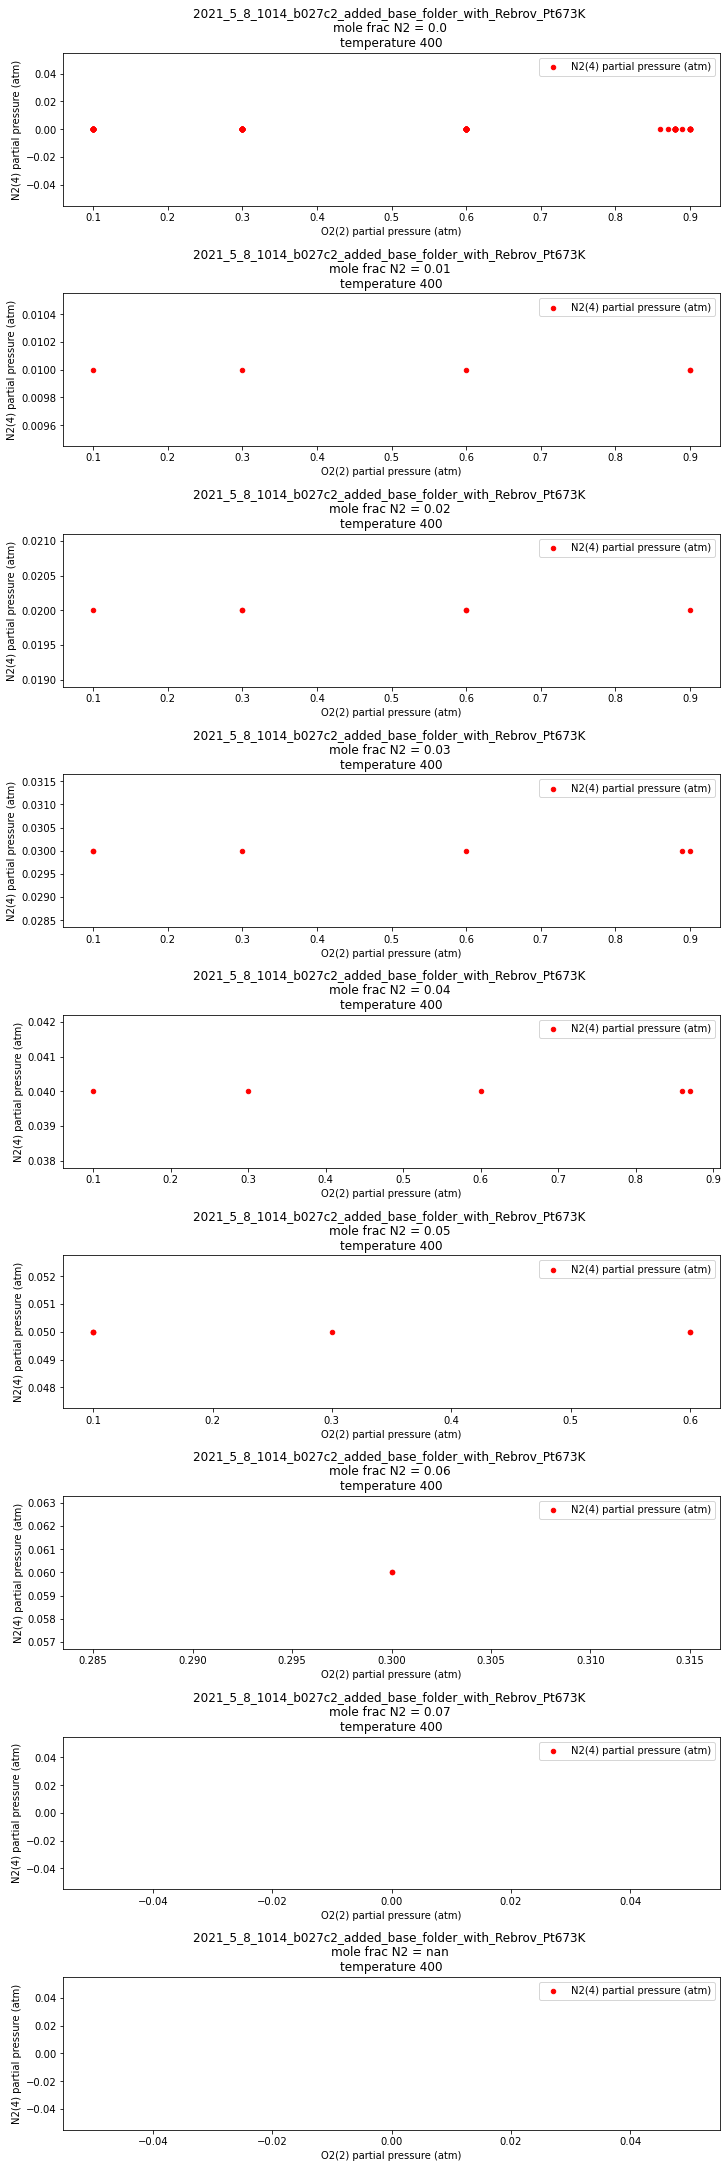

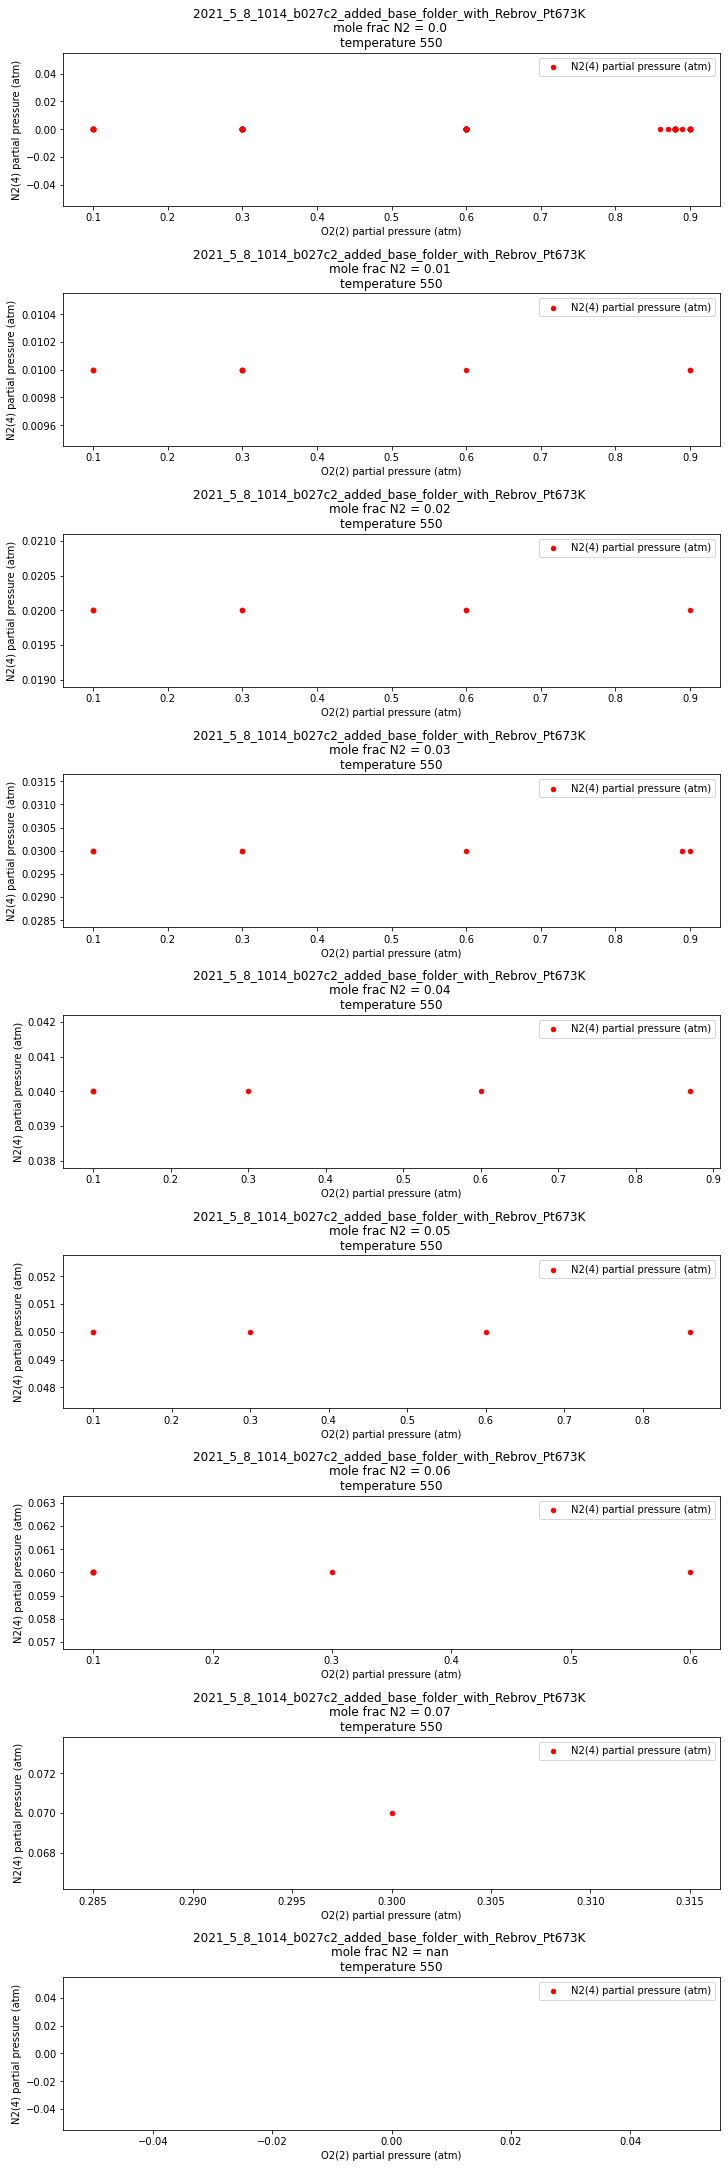

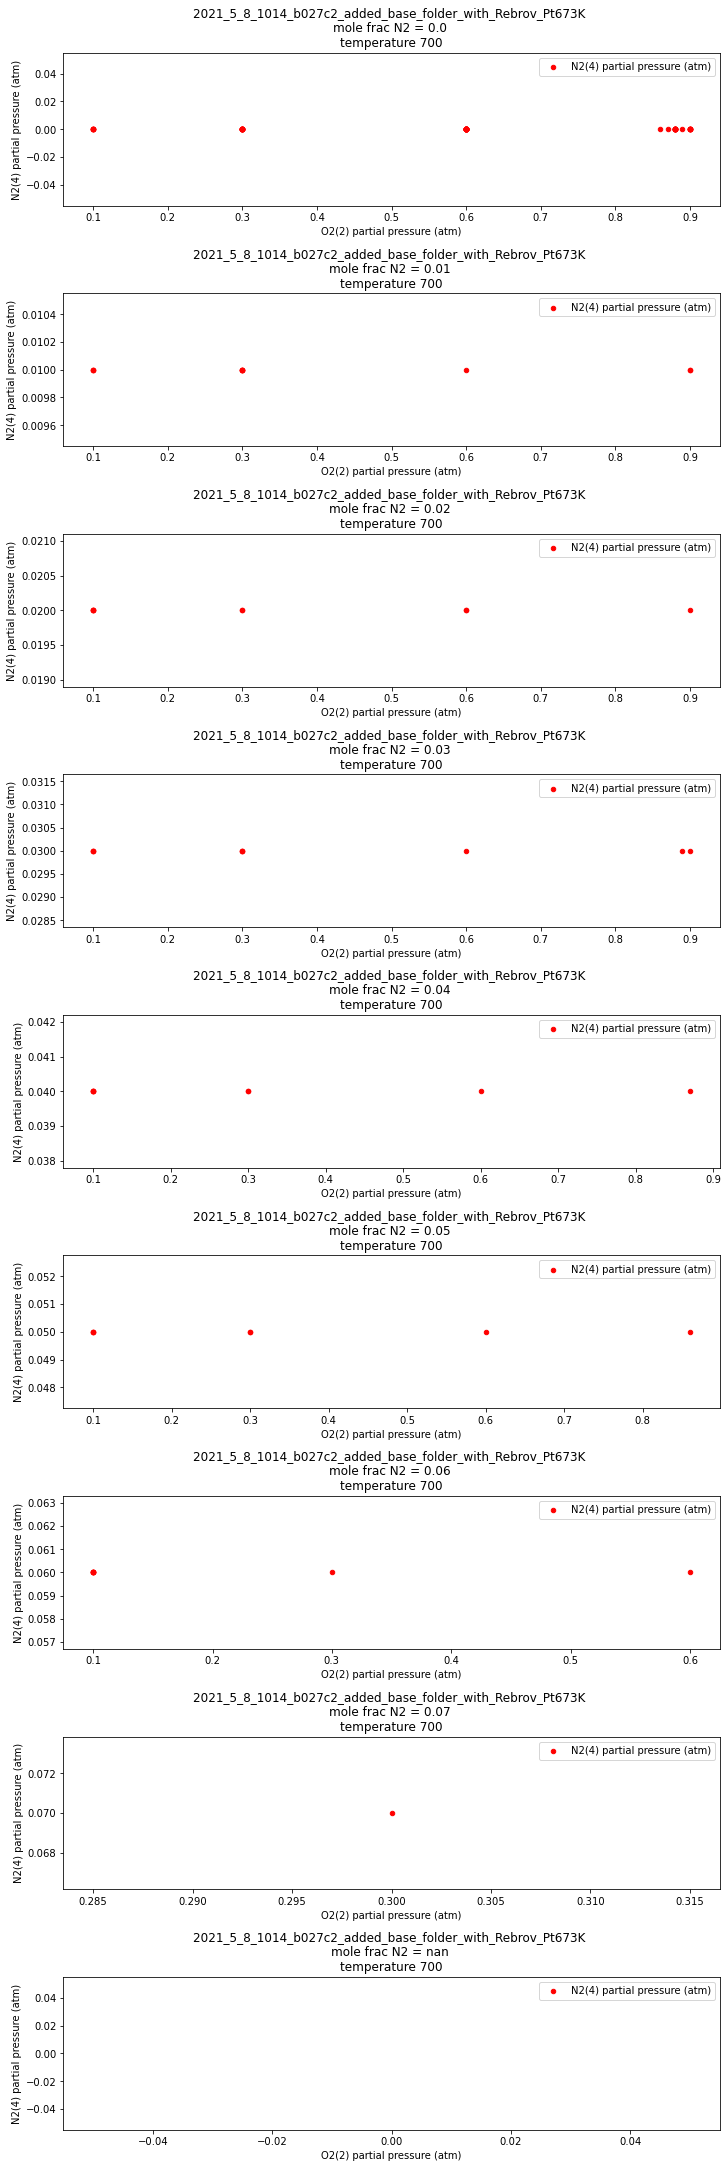

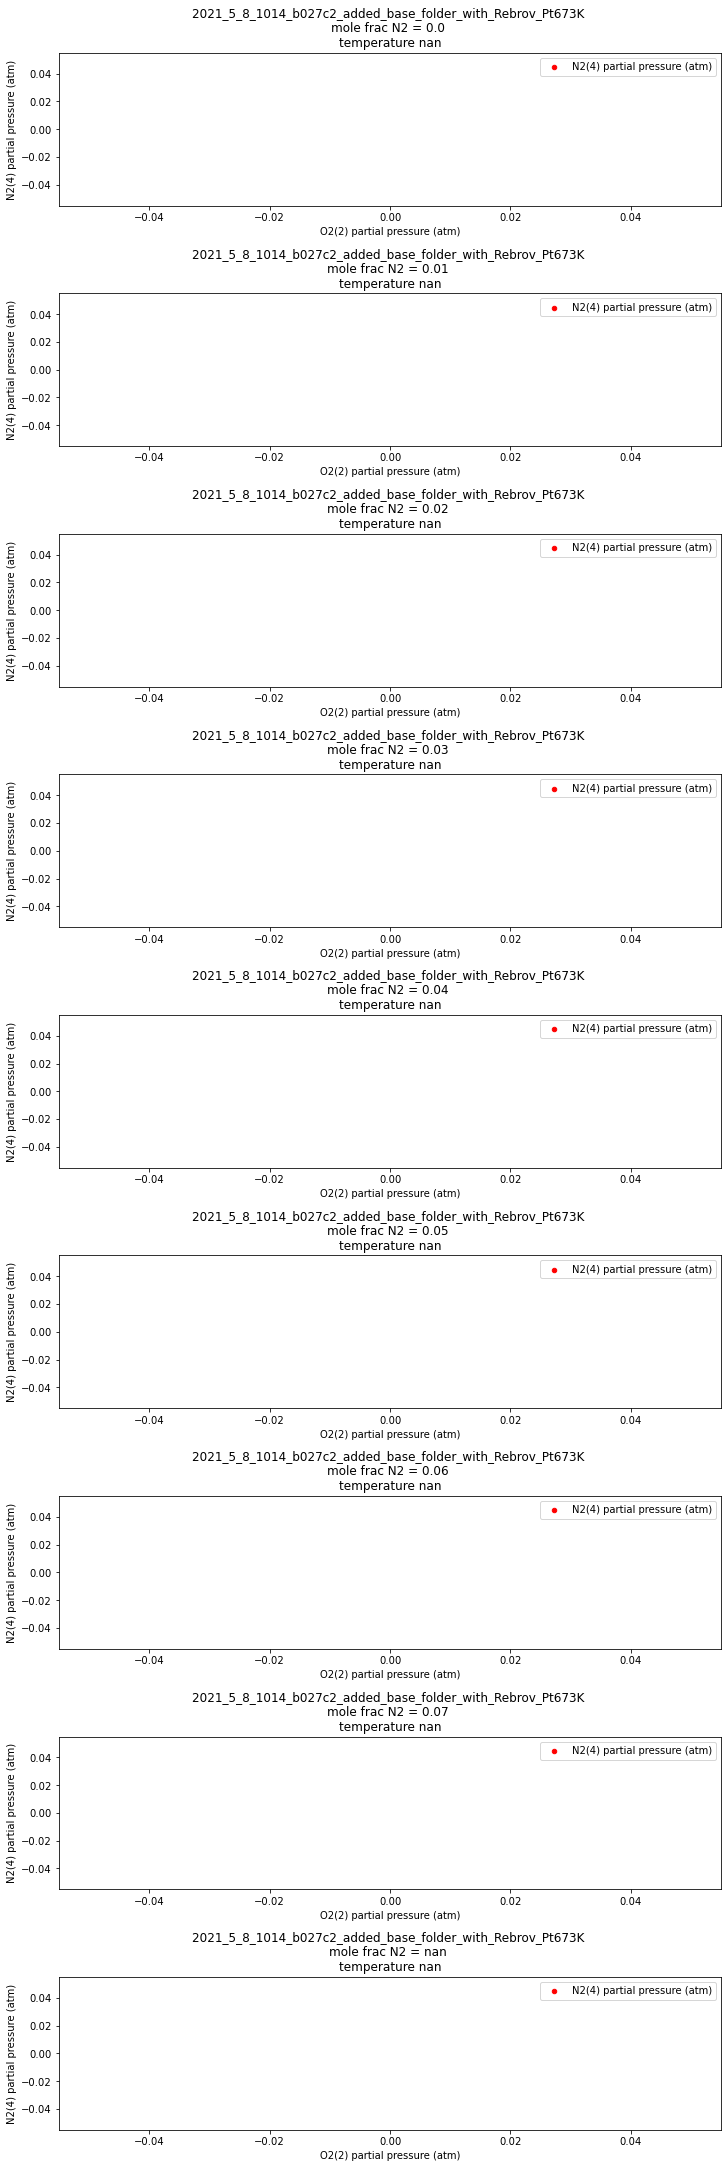

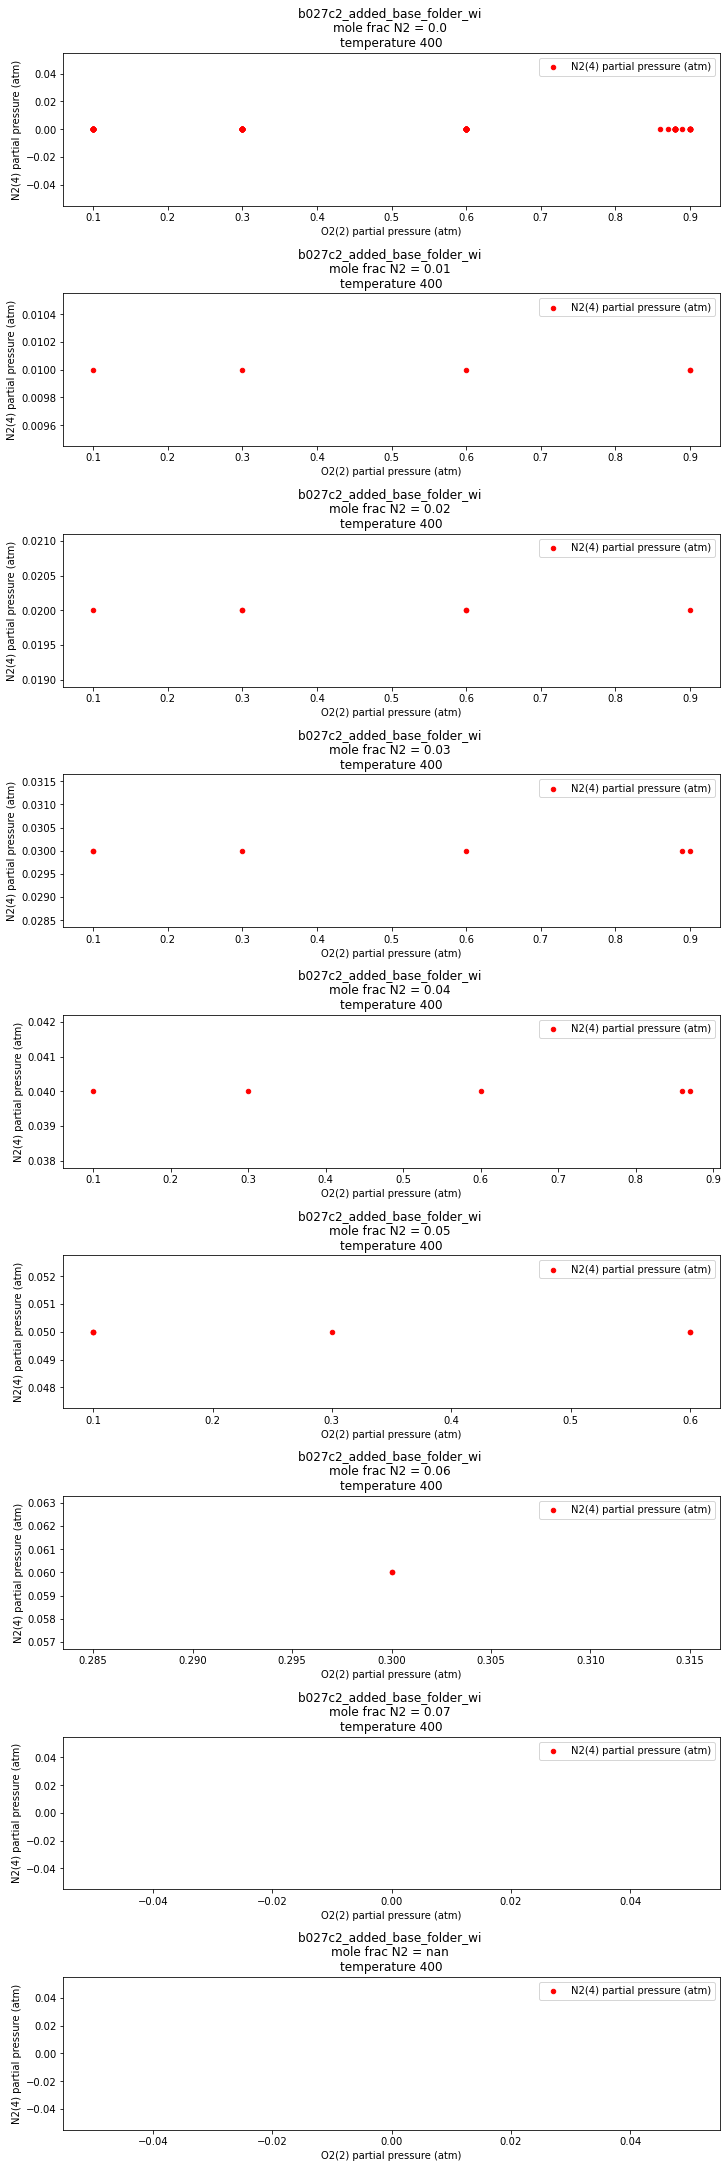

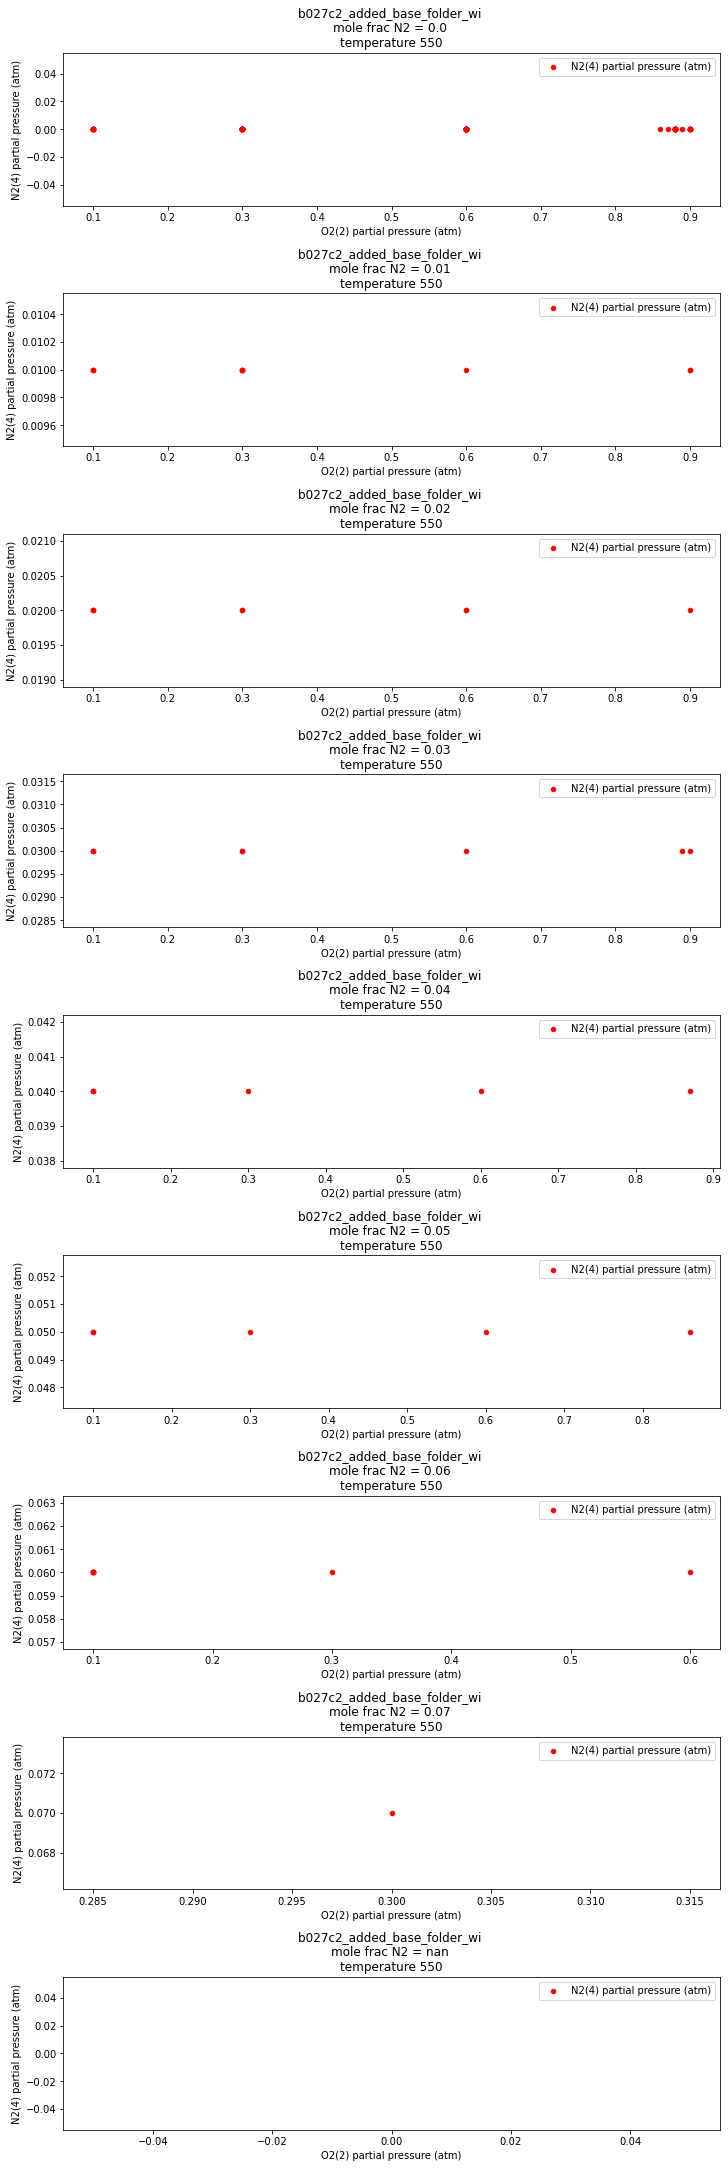

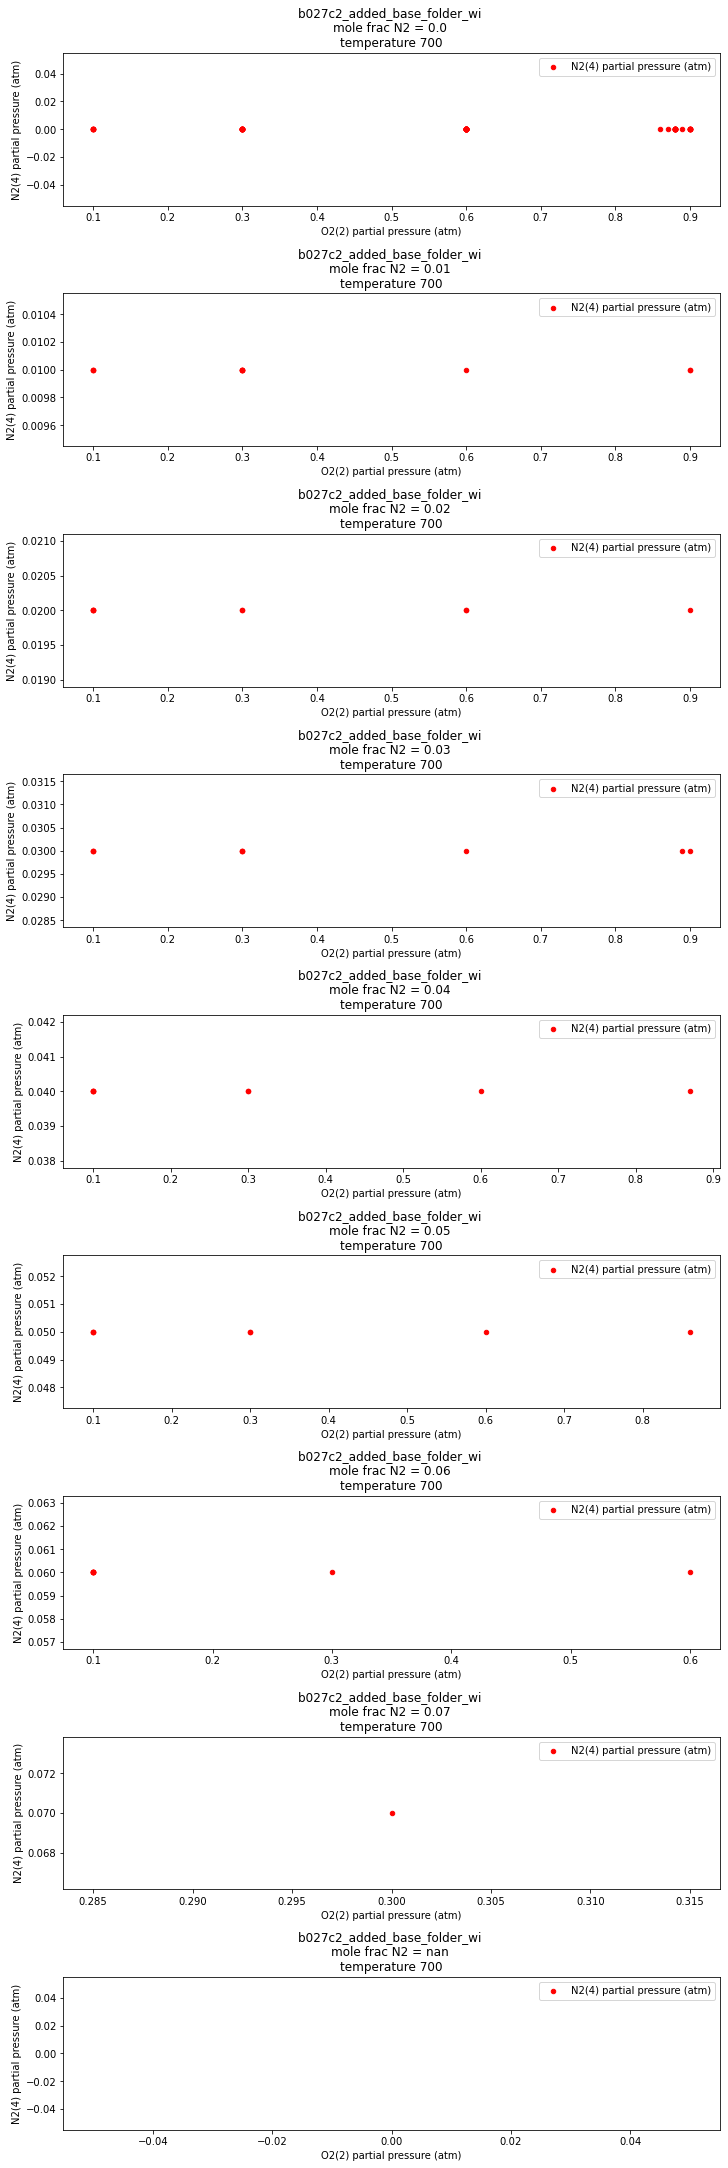

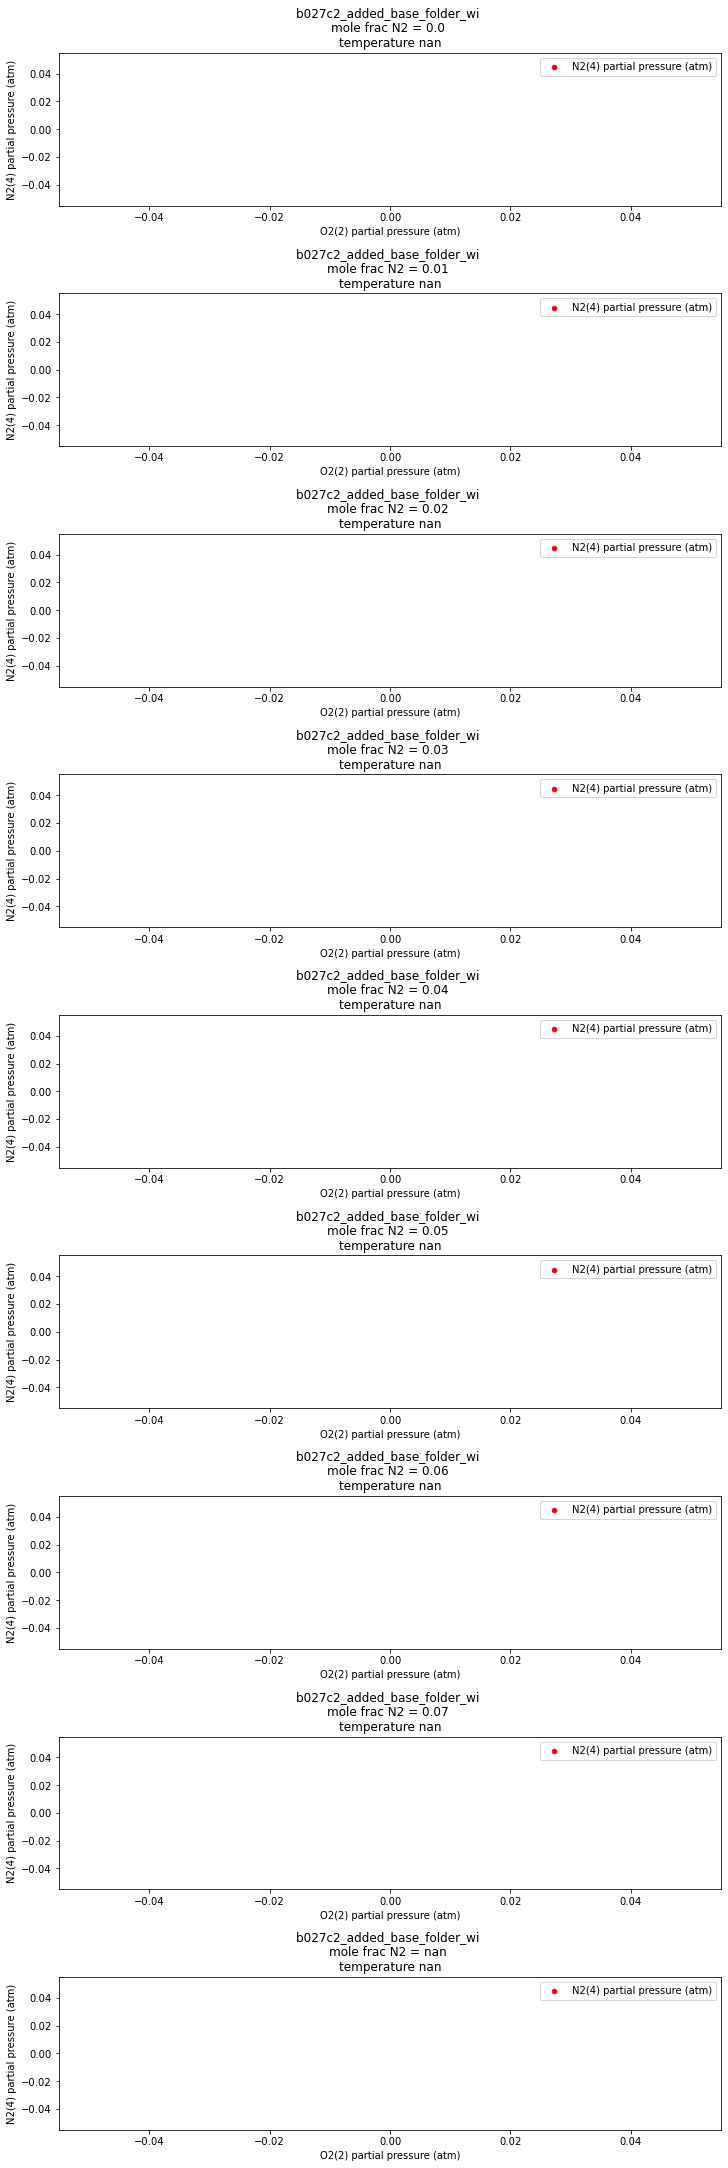

In [16]:
for commit in commit_list:
    
    for temp in temps:
        # get keys for O2 (X_o2 initial)
        o2_ratio = data_dict[commit_list[0]]['O2(2) partial pressure (atm)'].unique()
        n2_ratio = data_dict[commit_list[0]]['N2(4) partial pressure (atm)'].unique()
        # set figure size 
        fig, ax = plt.subplots(len(n2_ratio),1,figsize=(10,30), constrained_layout = True)
        # make a list of markers
        color_dict = { 0:"r", 1:"gold", 2:"pink", 3:"yellowgreen",4:"lightskyblue"}
    
        for f,j in enumerate(n2_ratio):
#             data_dict[commit][(data_dict[commit]['O2(2) partial pressure (atm)'] == j) &
#                              (data_dict[commit]['T (C)'] == temp)].plot.scatter(x='NH3(6) partial pressure (atm)', 
#                                                                                  y='NH3(6) conversion (%)', 
#                                                                                  label='NH3(6) conversion (%)', 
#                                                                                  ax=ax[p], 
#                                                                                  color="blue")
            data_dict[commit][(data_dict[commit]['N2(4) partial pressure (atm)'] == j) &
                             (data_dict[commit]['T (C)'] == temp)].plot.scatter(x='O2(2) partial pressure (atm)', 
                                                                                 y='N2(4) partial pressure (atm)', 
                                                                                 label='N2(4) partial pressure (atm)', 
                                                                                 ax=ax[f], 
                                                                                 color="red")            
#             ax[p].set_title(f'{commit} \nmole frac O2 = {j} \ntemperature {temp}')
            ax[f].set_title(f'{commit} \nmole frac N2 = {j} \ntemperature {temp}')
            

description of commits: 


In [1]:
f, ax = plt.subplots(3,2, figsize=(9,9), dpi=96)
ax[0,0].plot(times, solution.values.y[:,0], color='C0')
ax[0,0].set_xlabel('Distance (m)')
ax[0,0].set_ylabel('Velocity (m/s)')

NameError: name 'plt' is not defined

In [29]:
# species partial pressures (for X-axis of plots)
p_p_species = ['O2(2)']

conversion_species = ['O2(2)']
selectivity_species = ['N2(4)','N2O(7)','NO(5)']

# this is H-site adsorption. no way to tell that from cantera 
coverage_species_1 = ['OX(10)', 'HOX(13)', 'X(1)'] 

# this is N-site adsorption. no way to tell that from cantera
coverage_species_2 = ['NOX(27)', 'NX(59)', 'H3NX(29)', 'X(1)']

In [40]:
N2(4).net_production_rates

NameError: name 'N2' is not defined

In [30]:
for commit in commit_list:
    for i in conversion_species:
        data_dict[commit]['O2(2) conversion (%)'] = 100*(data_dict[commit]['X_o2 initial'] - data_dict[commit][i])/data_dict[commit]['X_o2 initial']        

In [31]:
#O2 initial partial pressure
for commit in commit_list:
    data_dict[commit][f'O2(2) partial pressure (atm)'] = data_dict[commit]['X_o2 initial']*data_dict[commit]['P (Pa)']/101325

In [32]:
#NH3 partial pressure
for commit in commit_list:
    data_dict[commit]['NH3(6) partial pressure (atm)'] = data_dict[commit]['X_nh3 initial']*(data_dict[commit]['P (Pa)']/101325)
    data_dict[commit]['NH3(6) partial pressure (atm)'] = data_dict[commit]['NH3(6) partial pressure (atm)'].round(decimals=2)

In [35]:
for commit in commit_list:
    for temp in temps:
        # get keys for NH3 (X_nh3 initial)
        nh3_ratio = data_dict[commit_list[0]]['NH3(6) partial pressure (atm)'].unique()
        n2_ratio = data_dict[commit_list[0]]['N2(4) partial pressure (atm)'].unique()
        # set figure size 
        #fig, ax = plt.subplots(len(nh3_ratio),1,figsize=(10,30), constrained_layout = True)
        fig, ax = ()
        # make a list of markers
        color_dict = { 0:"r", 1:"gold", 2:"pink", 3:"yellowgreen",4:"lightskyblue"}
        
        for p,j in enumerate(nh3_ratio):
            data_dict[commit][(data_dict[commit]['NH3(6) partial pressure (atm)'] == j) &
                             (data_dict[commit]['T (C)'] == temp)].plot.scatter(x='O2(2) partial pressure (atm)', 
                                                                                y='NH3(6) conversion (%)', 
                                                                                label='NH3(6) conversion (%)', 
                                                                                ax=ax[p], 
                                                                                color="r")

            ax[p].set_title(f'{commit} \nmole frac NH3 = {j} \ntemperature {temp}')
        for p,j in enumerate(n2_ratio):
            data_dict[commit][(data_dict[commit]['N2(4) partial pressure (atm)'] == j) &
                             (data_dict[commit]['T (C)'] == temp)].plot.scatter(x='O2(2) partial pressure (atm)', 
                                                                                y='N2(4) conversion (%)', 
                                                                                label='N2(4) conversion (%)', 
                                                                                ax=ax[p], 
                                                                                color="r")

            ax[p].set_title(f'{commit} \nmole frac N2 = {j} \ntemperature {temp}')

KeyError: 'N2(4) partial pressure (atm)'